In [7]:
import pandas as pd
import statsmodels.api as sm
from sklearn.model_selection import train_test_split

In [8]:
# Load the dataset
data_path = 'data_preprocess2.csv'
data = pd.read_csv(data_path)

# Display the first few rows of the dataset and summary statistics
data.head(), data.describe(), data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3862 entries, 0 to 3861
Data columns (total 31 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   delirium                3862 non-null   int64  
 1   subject_id              3862 non-null   int64  
 2   hadm_id                 3862 non-null   int64  
 3   stay_id                 3862 non-null   int64  
 4   icu_length_of_stay_day  3862 non-null   float64
 5   age                     3862 non-null   int64  
 6   weight                  3862 non-null   float64
 7   duration_hours          3862 non-null   float64
 8   avg_dose                3862 non-null   float64
 9   max_dose                3862 non-null   float64
 10  gender                  3862 non-null   object 
 11  avg_gcs                 3862 non-null   float64
 12  avg_gcs_motor           3862 non-null   float64
 13  avg_gcs_verbal          3862 non-null   float64
 14  avg_gcs_eyes            3862 non-null   

(   delirium  subject_id   hadm_id   stay_id  icu_length_of_stay_day  age  \
 0         1    19334906  27475948  39446511                0.863472   34   
 1         1    18909954  22019360  39532690                3.677975   85   
 2         0    10038081  20755971  38430513                3.698519   63   
 3         0    14534699  28038972  37097825               11.970602   79   
 4         1    13423633  23346659  32889695                9.204479   56   
 
    weight  duration_hours  avg_dose   max_dose  ... avg_heart_rate    avg_mbp  \
 0    70.0        1.016667  1.201186   1.201186  ...      80.260870  72.190476   
 1    71.4       51.650000  1.407078   2.400960  ...      83.333333  73.458333   
 2    67.1       15.716667  1.556666   2.388060  ...     100.890909  50.424528   
 3    90.0       51.633333  4.526536  13.163397  ...      92.097792  75.393082   
 4    62.0       49.516667  3.386109   4.789492  ...      91.956710  90.931330   
 
    avg_resp_rate  avg_temperature   avg_s

# Regression Model

/var/folders/k5/5frv3n695tz12pvhhf2wxb7m0000gp/T/ipykernel_33921/2649602841.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_data['gender_numeric'] = selected_data['gender'].apply(lambda x: 1 if x == 'M' else 0)


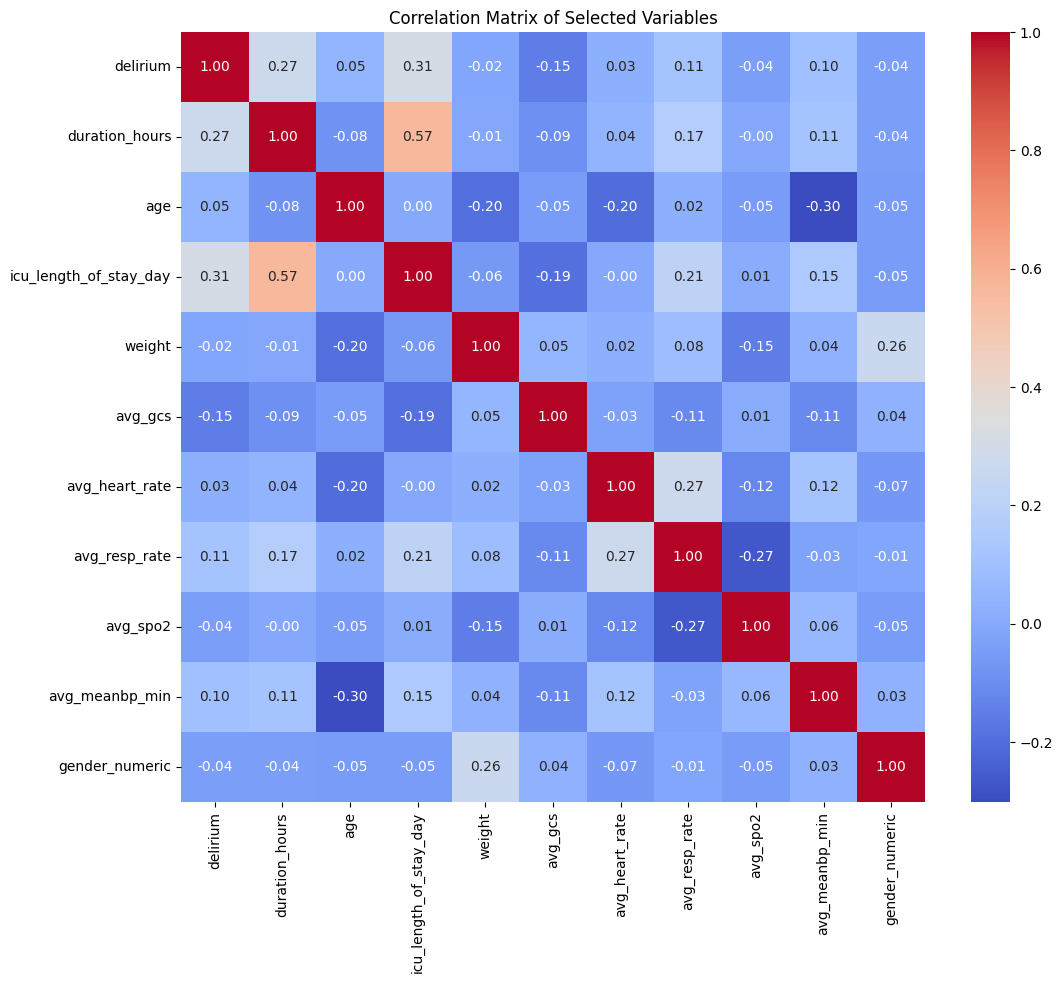

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt

# Select potential confounders and the main variables
selected_columns = [
    'delirium', 'duration_hours', 'age', 'icu_length_of_stay_day',
    'weight', 'avg_gcs', 'avg_heart_rate', 'avg_resp_rate', 'avg_spo2',
    'avg_meanbp_min', 'gender'
]

# Create a smaller dataframe with only selected columns
selected_data = data[selected_columns]

# Convert 'gender' to a numeric format for correlation calculation
selected_data['gender_numeric'] = selected_data['gender'].apply(lambda x: 1 if x == 'M' else 0)

# Compute the correlation matrix
correlation_matrix = selected_data.drop(columns=['gender']).corr()

# Plot the heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix of Selected Variables")
plt.show()


In [11]:
# Prepare the data for modeling
X = selected_data[['duration_hours', 'age', 'icu_length_of_stay_day', 'weight', 
                   'avg_gcs', 'avg_heart_rate', 'avg_resp_rate', 'avg_spo2', 'avg_meanbp_min', 
                   'gender_numeric']]
y = selected_data['delirium']

# Adding constant for logistic regression with statsmodels
X = sm.add_constant(X)

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit the logistic regression model
model = sm.Logit(y_train, X_train)
result = model.fit()

# Print the summary of the regression
result.summary()


Optimization terminated successfully.
         Current function value: 0.574052
         Iterations 5


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:               delirium   No. Observations:                 3089
Model:                          Logit   Df Residuals:                     3078
Method:                           MLE   Df Model:                           10
Date:                Sat, 13 Apr 2024   Pseudo R-squ.:                  0.1017
Time:                        17:46:04   Log-Likelihood:                -1773.2
converged:                       True   LL-Null:                       -1974.0
Covariance Type:            nonrobust   LLR p-value:                 4.707e-80
==========================================================================================
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                      4.5528      2.816      1.617      0.106      -0.967      10.073
duration_hours             0.0093      0.001      6.349      0.000       0.006       0.012
age                        0.0140      0.003      4.431      0.000       0.008       0.020
icu_length_of_stay_day     0.0966      0.012      7.849      0.000       0.072       0.121
weight                     0.0013      0.002      0.698      0.485      -0.002       0.005
avg_gcs                   -0.2979      0.057     -5.230      0.000      -0.410      -0.186
avg_heart_rate             0.0043      0.004      1.190      0.234      -0.003       0.011
avg_resp_rate              0.0108      0.015      0.727      0.467      -0.018       0.040
avg_spo2                  -0.0490      0.026     -1.911      0.056      -0.099       0.001
avg_meanbp_min             0.0208      0.005      4.341      0.000       0.011       0.030
gender_numeric            -0.0922      0.086     -1.068      0.286      -0.261       0.077
==========================================================================================
"""